### Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров 
(да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).
У вас есть несколько ресторанов в разных частях города и целый штат курьеров. 
Но есть одна проблема — к вечеру скорость доставки падает из-за того, 
что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. 
Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 
Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои 
последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. 
То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 
Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. 
Часть курьеров использует старый алгоритм без опции "по пути", 
другие видят в своем приложении эту опцию и могут ее выбрать. 
Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке 
новой фичи на всех курьеров.

In [2]:
import pandas as pd 
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy import stats
import numpy as np
%matplotlib inline

### Нулевая гипотеза всегда об отсутствии различий, альтернативная - об их наличии

###                                        Определим необходимые гипотезы 
    
H0 Разницы между средним временем доставки в тестовой и контрольной группе нет

H1 Разница между средним временем доставки в тестовой и контрольной группе есть

In [3]:
df = pd.read_csv('/Users/anastasialutsuk/Desktop/карпов/experiment_lesson_4.csv')

/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

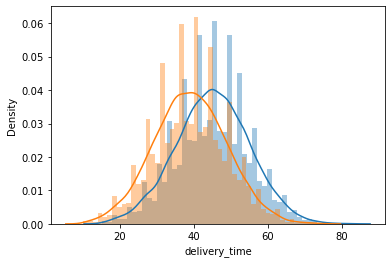

In [4]:
# Сравним плотность распределения показателей delivery_time (время доставки в минутах) в двух группах
sns.distplot(df[df.experiment_group == 'control'].delivery_time)
sns.distplot(df[df.experiment_group == 'test'].delivery_time)

<AxesSubplot:>

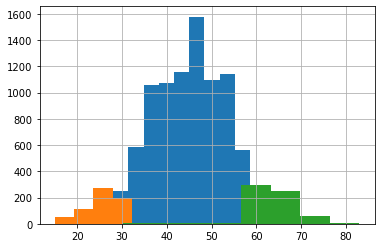

In [5]:
# Сравним распределения показателей delivery_time (время доставки в минутах) относительно district
# Группа контрольная
df.query("(experiment_group == 'control') & (district == 'Purlieus')").delivery_time.hist()
df.query("(experiment_group == 'control') & (district == 'Central')").delivery_time.hist()
df.query("(experiment_group == 'control') & (district == 'Suburb')").delivery_time.hist()

<AxesSubplot:>

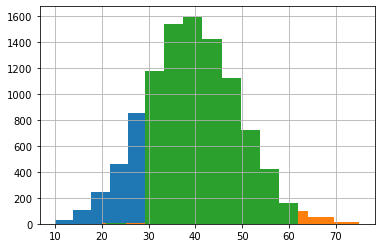

In [6]:
# Сравним распределения показателей delivery_time (время доставки в минутах) относительно district
# Группа тестовая
df.query("(experiment_group == 'test') & (district == 'Central')").delivery_time.hist()
df.query("(experiment_group == 'test') & (district == 'Suburb')").delivery_time.hist()
df.query("(experiment_group == 'test') & (district == 'Purlieus')").delivery_time.hist()

In [7]:
#Посчитаем количество наблюдений в тестовой и контрольной группе.
g1 = int(df.groupby('experiment_group', as_index=False)\
  .agg({'order_id' : 'count'}).query('experiment_group == "test"').order_id)
g2 = int(df.groupby('experiment_group', as_index=False)\
  .agg({'order_id' : 'count'}).query('experiment_group == "control"').order_id)
g1 - g2

12

In [8]:
# Теперь давайте изучим наши распределения. 
# Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.
# Тест Шапиро-Уилка 
# Cделаем семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), 
# так как на больших выборках вы можете получать неверные результаты: 
first_sample = df[df['experiment_group'] == 'test'].sample(1000, random_state=17)
second_sample = df[df['experiment_group'] == 'control'].sample(1000, random_state=17)

In [10]:
print(stats.shapiro(first_sample.delivery_time)) 
print(stats.shapiro(second_sample.delivery_time))
# pvalue > 0.05, => распределния приближены к нормальным 

ShapiroResult(statistic=0.9975479245185852, pvalue=0.14013493061065674)
ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)


In [ ]:
# Проверим отличается ли у нас стандартное отклонение

In [14]:
print('Тестовая группа ' + str(np.std(df[df['experiment_group'] == 'test'].delivery_time, ddof=1)))
print('Контрольная группа ' + str(np.std(df[df['experiment_group'] == 'control'].delivery_time, ddof=1)))

Тестовая группа 9.883308351129031
Контрольная группа 9.990016960247171


In [16]:
# Пришло время сравнить средние в тесте и контроле.
# Внимание: здесь уже не нужно пользоваться методом .sample() — он нам нужен был только для теста Шапиро-Уилка,
# остальные тесты надо проводить на полных данных.
# Т.к данные у нас расп. нормально используем t-test
ttest_ind(df[df['experiment_group'] == 'test'].delivery_time,
          df[df['experiment_group'] == 'control'].delivery_time)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [15]:
# Мы получили статистически значимые различия pvalue < 0.05. У нас нет основания принимать H0

In [17]:
# Посмотрим на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной 
# среднее время 
mean1 = df[df['experiment_group'] == 'test'].delivery_time.mean() 
mean2 = df[df['experiment_group'] == 'control'].delivery_time.mean()
round((1 - (mean1/mean2))*100,2)

13.35

Раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. 
Среднее время доставки в тесте меньше, чем в контроле.